In [53]:
using Oceananigans
using Oceananigans.Units
using Oceananigans.OutputReaders: FieldTimeSeries

In [54]:
Lx = 100kilometers # north-south extent [m]
Lz = 1kilometers    # depth [m]

grid = RectilinearGrid(size = (48, 8),
                       x = (-Lx/2, Lx/2),
                       z = (-Lz, 0),
                       topology = (Bounded, Flat, Bounded))

                       

48×1×8 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── Bounded  x ∈ [-50000.0, 50000.0] regularly spaced with Δx=2083.33
├── Flat y                           
└── Bounded  z ∈ [-1000.0, 0.0]      regularly spaced with Δz=125.0

In [55]:
#= α = 0  # strain rate
f = 1e-4  # Coriolis parameter [s⁻¹] at 45° latitude

@inline u_deformation(x, z, t) = -α * x  # Convergent flow U = -αx
#@inline v_deformation(x, z, t) =  α * y  # Compensating vertical motion

# Pack into NamedTuple for model forcing
deformation_forcing = (u=Forcing(u_deformation))
                       #w=Forcing(w_deformation) =#



In [56]:
f = 1e-4
α = 0

#= u_background(x, z, t) = 0 #-α * x 

background_flow = AdvectiveForcing(u = u_background) =#

background_flow = AdvectiveForcing(u = 1)

AdvectiveForcing:
├── u: ConstantField(1)
├── v: ZeroField{Int64}
└── w: ZeroField{Int64}

In [57]:
model = NonhydrostaticModel(; grid,
                coriolis = FPlane(f = f),
                buoyancy = BuoyancyTracer(),
                tracers = :b,
                advection = WENO(),
                forcing = (; u = background_flow, v = background_flow, w = background_flow, b = background_flow))


NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 48×1×8 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: WENO(order=5)
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: FPlane{Float64}(f=0.0001)

In [58]:
# Initial condition setup (similar to your code but adjusted for frontogenesis)
N² = 1e-6  # [s⁻²] background stratification
M² = 1e-6  # [s⁻²] horizontal buoyancy gradient (front strength)

Δx = 10kilometers  # initial front width
Δb = Δx * M²       # buoyancy jump across front
ϵb = 1e-2 * Δb     # noise amplitude

ramp(x, Δx) = min(max(0, x/Δx + 1/2), 1)
bᵢ(x, z) = N² * z + Δb * ramp(x, Δx) + ϵb * randn()

set!(model, b=bᵢ, u=0, v=0, w=0)  # Start from rest


In [59]:
simulation = Simulation(model, Δt=20minutes, stop_time=30days)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 30 days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [60]:
conjure_time_step_wizard!(simulation, IterationInterval(20), cfl=0.1, max_Δt=20minutes)

In [61]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)
    u, v, w = model.velocities
    progress = 100 * (time(sim) / sim.stop_time)
    elapsed = (time_ns() - wall_clock[]) / 1e9

    @printf("[%05.2f%%] i: %d, t: %s, wall time: %s, max(u): (%6.3e, %6.3e, %6.3e) m/s, next Δt: %s\n",
            progress, iteration(sim), prettytime(sim), prettytime(elapsed),
            maximum(abs, u), maximum(abs, v), maximum(abs, w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    return nothing
end

add_callback!(simulation, print_progress, IterationInterval(100))

Diagnostic/Output

In [64]:
# Output setup
filename = "frontogenesis_2D"
u, v, w = model.velocities
ζ = ∂z(u) - ∂x(w)  # Vorticity in x-z plane
b = model.tracers.b

simulation.output_writers[:fields] = JLD2Writer(
    model, (; b, ζ , u, v, w),
    filename=filename * ".jld2",
    schedule=TimeInterval(0.5day),
    overwrite_existing=true 
) 

JLD2Writer scheduled on TimeInterval(12 hours):
├── filepath: frontogenesis_2D.jld2
├── 5 outputs: (b, ζ, u, v, w)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 41.4 KiB

In [ ]:
@info "Running the simulation..."

run!(simulation)

@info "Simulation completed in " * prettytime(simulation.run_wall_time)

[00.00%] i: 0, t: 0 seconds, wall time: 844.964 ms, max(u): (0.000e+00, 0.000e+00, 0.000e+00) m/s, next Δt: 20 minutes


[ Info: Running the simulation...
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (82.561 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (9.256 ms).


[01.84%] i: 100, t: 13.234 hours, wall time: 2.264 seconds, max(u): (1.128e+00, 1.404e+00, 4.780e-02) m/s, next Δt: 2.168 minutes
[02.35%] i: 200, t: 16.909 hours, wall time: 766.920 ms, max(u): (9.172e-01, 9.025e-01, 9.407e-02) m/s, next Δt: 2.001 minutes
[02.91%] i: 300, t: 20.981 hours, wall time: 648.267 ms, max(u): (5.163e-01, 2.798e-01, 4.874e-02) m/s, next Δt: 3.223 minutes
[03.82%] i: 400, t: 1.147 days, wall time: 628.365 ms, max(u): (3.237e-02, 5.841e-02, 5.239e-03) m/s, next Δt: 5.190 minutes
[05.26%] i: 500, t: 1.579 days, wall time: 639.680 ms, max(u): (5.691e-04, 7.144e-04, 5.835e-05) m/s, next Δt: 8.359 minutes
[07.62%] i: 600, t: 2.286 days, wall time: 662.548 ms, max(u): (2.547e-04, 2.962e-04, 1.457e-05) m/s, next Δt: 13.462 minutes
[11.37%] i: 700, t: 3.411 days, wall time: 695.174 ms, max(u): (7.413e-05, 8.637e-05, 4.132e-06) m/s, next Δt: 20 minutes
[15.97%] i: 800, t: 4.792 days, wall time: 790.083 ms, max(u): (1.629e-05, 1.906e-05, 8.795e-07) m/s, next Δt: 20 minu

[ Info: Simulation is stopping after running for 20.298 seconds.
[ Info: Simulation time 30 days equals or exceeds stop time 30 days.
[ Info: Simulation completed in 20.358 seconds


In [ ]:
# Visualization
b_ts = FieldTimeSeries(filename * ".jld2", "b")
ζ_ts = FieldTimeSeries(filename * ".jld2", "ζ")

u_ts = FieldTimeSeries(filename * ".jld2", "u")
v_ts = FieldTimeSeries(filename * ".jld2", "v")
w_ts = FieldTimeSeries(filename * ".jld2", "w")

times = b_ts.times

LoadError: KeyError: key "timeseries/ζ" not found

In [ ]:
# Coordinates
y = ynodes(grid, Center())# ./ 1e3  # km
z = znodes(grid, Center())# ./ 1e3  # km

8-element view(OffsetArray(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, -2:11), 1:8) with eltype Float64:
 -937.5
 -812.5
 -687.5
 -562.5
 -437.5
 -312.5
 -187.5
  -62.5

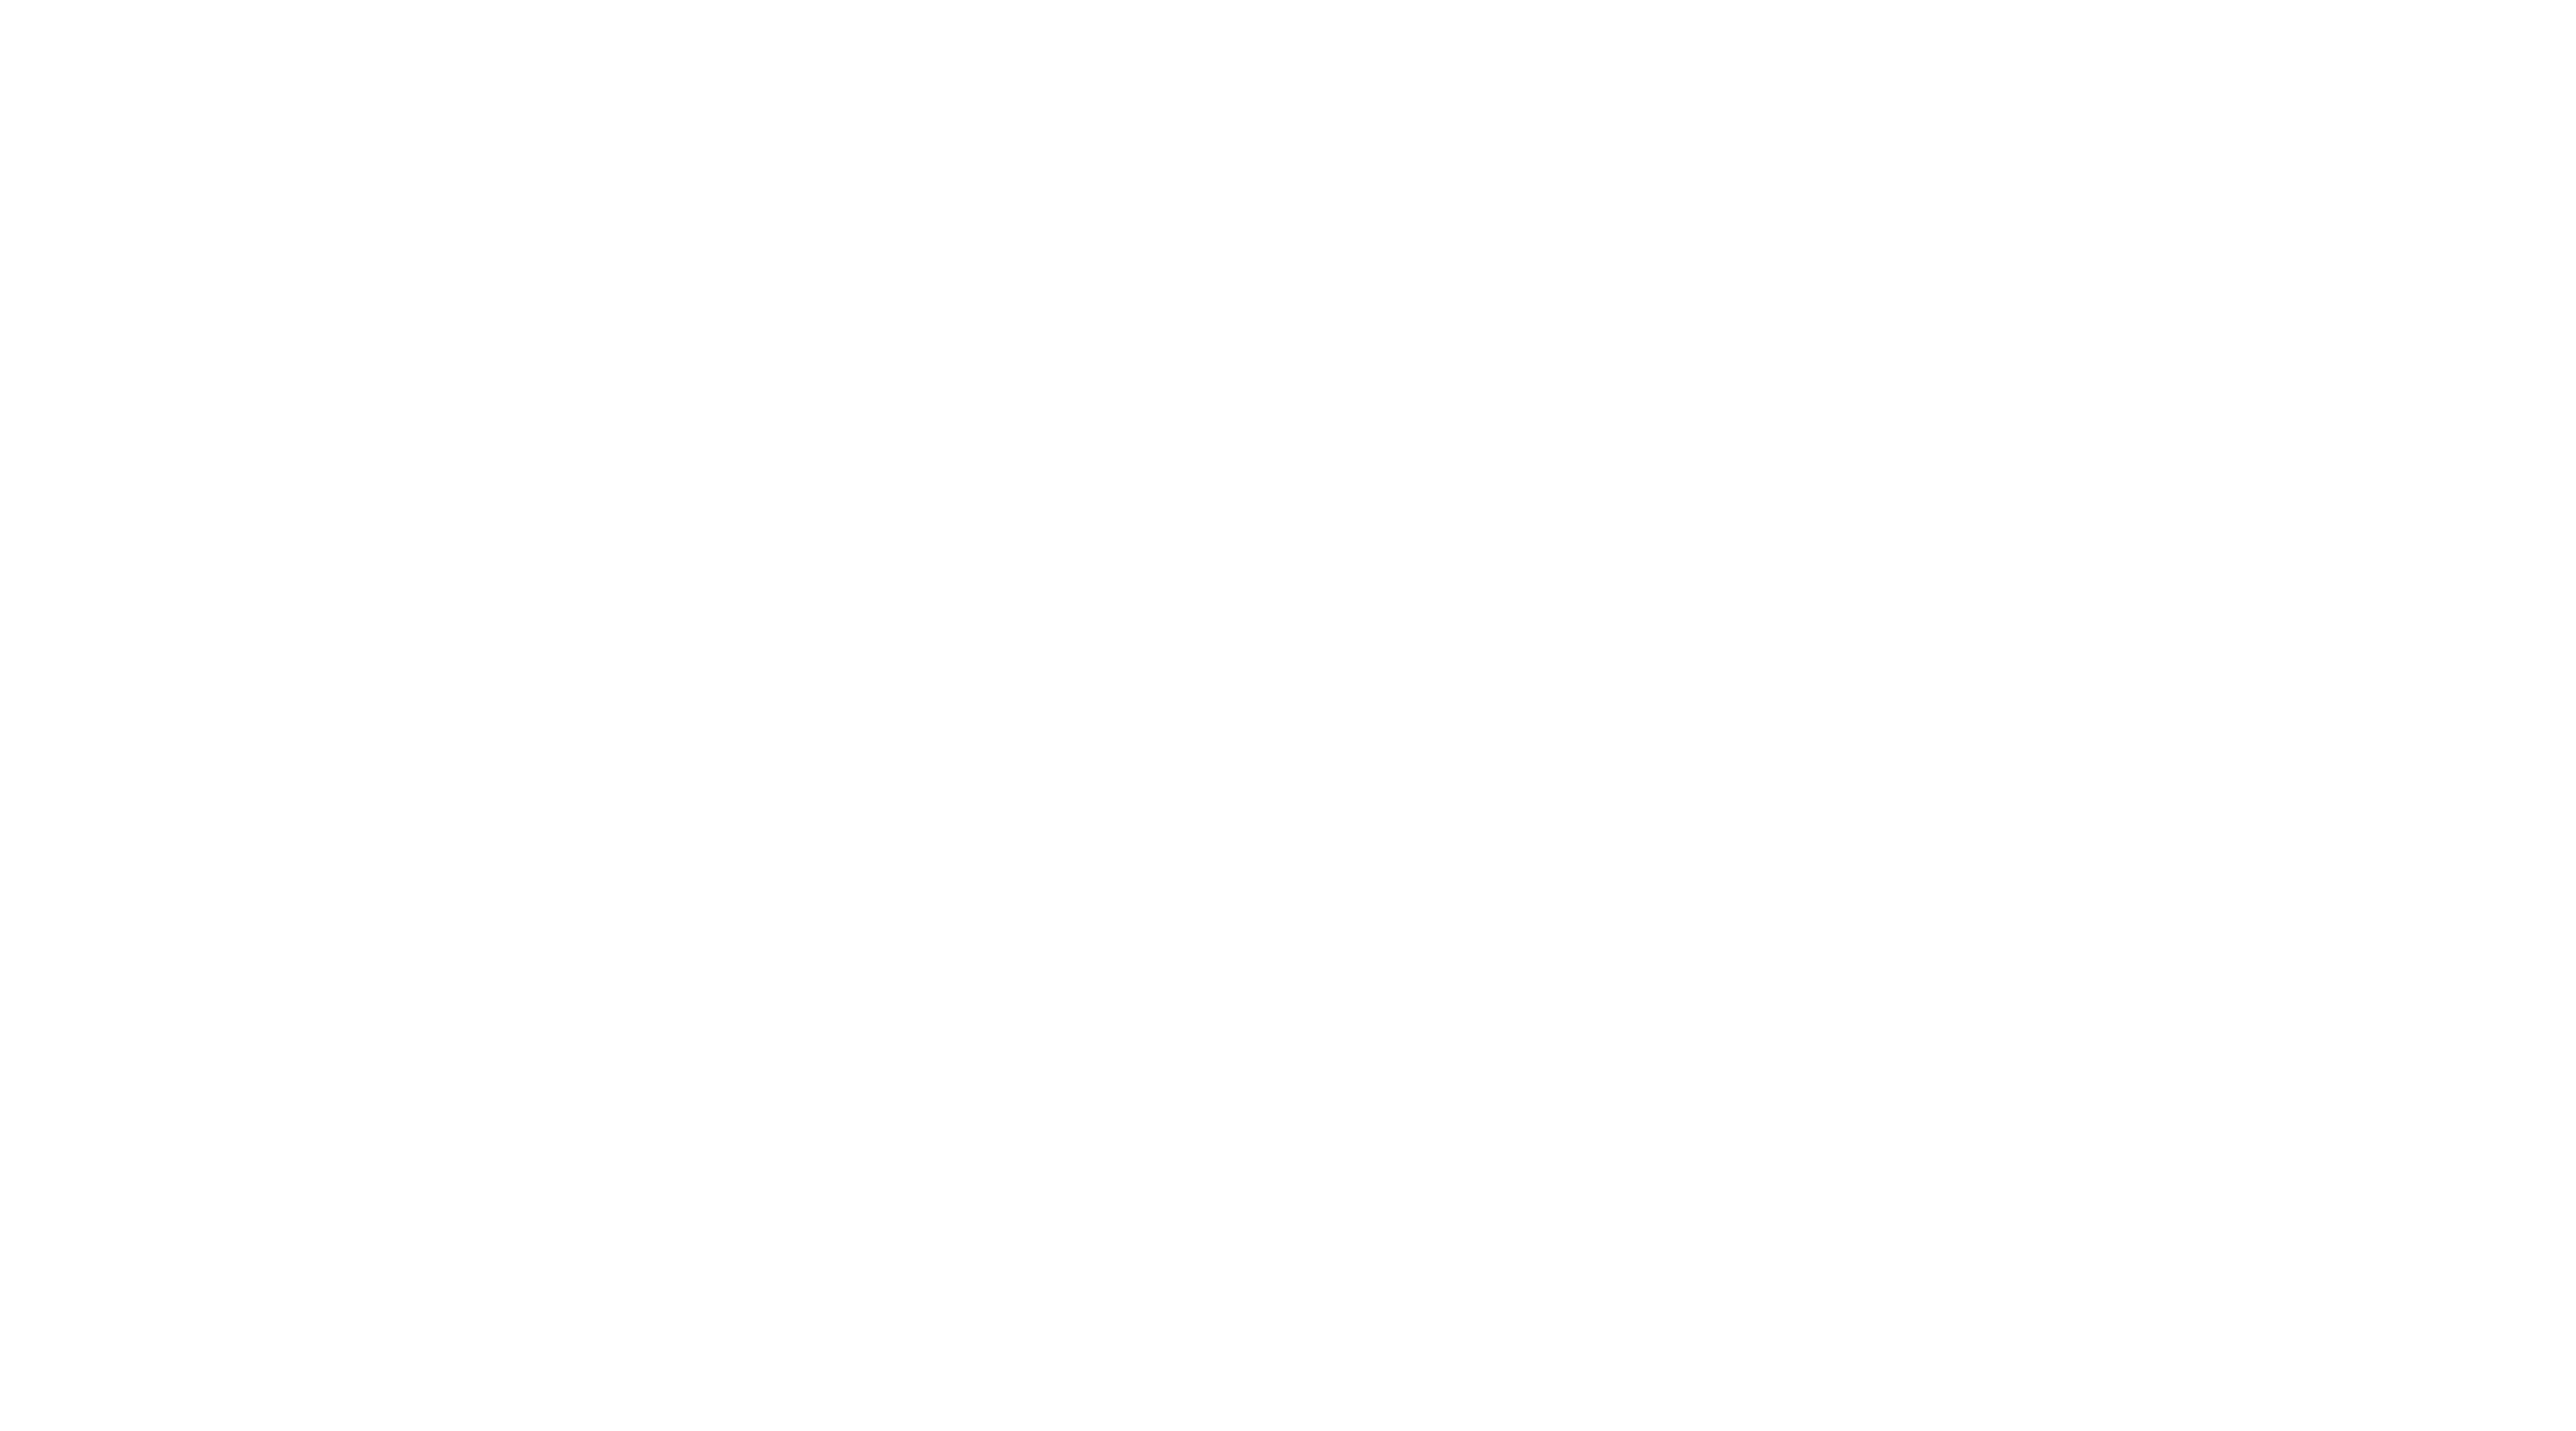

In [ ]:
using CairoMakie
fig = Figure(size=(1800, 1000))

In [ ]:
# Animation setup
n = Observable(1)
b_slice = @lift interior(b_ts[$n], 1, :, :)
#ζ_slice = @lift interior(ζ_ts[$n], 1, :, :)

u_slice = @lift interior(u_ts[$n], 1, :, :)
v_slice = @lift interior(v_ts[$n], 1, :, :)
w_slice = @lift interior(w_ts[$n], 1, :, :)

title_text = @lift "Day $(round(times[$n]/day, digits=1))"

Observable("Day 0.0")


In [ ]:
# Animations of Buoyancy and Vorticity



empty!(fig)

# Buoyancy plot
ax_b = Axis(fig[1, 1], title="Buoyancy", xlabel="y [m]", ylabel="z [m]")
hm_b = heatmap!(ax_b, y, z, b_slice, colorrange=(0, Δb), colormap=:thermal)
contour!(ax_b, y, z, b_slice, levels=10, color=:black, linewidth=0.5)
Colorbar(fig[1, 2], hm_b, label="Buoyancy [m s⁻²]")

# Vorticity plot
ax_ζ = Axis(fig[1, 3], title="Vorticity", xlabel="y [m]")
hm_ζ = heatmap!(ax_ζ, y, z, ζ_slice, colorrange=(-3e-3, 3e-3), colormap=:balance)
contour!(ax_ζ, y, z, b_slice, levels=10, color=:black, linewidth=0.5)  # Overlay buoyancy contours
Colorbar(fig[1, 4], hm_ζ, label="Vorticity [s⁻¹]")

Label(fig[0, :], title_text, fontsize=24)

# Create animation
frames = 1:length(times)
record(fig, filename * "_animation.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame



LoadError: ArgumentError:     Conversion failed for Heatmap (With conversion trait CellGrid()) with args: Tuple{Nothing, SubArray{Float64, 1, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, Tuple{UnitRange{Int64}}, true}, SubArray{Float64, 2, Array{Float64, 4}, Tuple{Int64, UnitRange{Int64}, UnitRange{Int64}, Int64}, false}} .
    Heatmap requires to convert to argument types Tuple{Union{AbstractVector{T} where T<:Real, MakieCore.EndPoints, AbstractMatrix{T} where T<:Real}, Union{AbstractVector{T} where T<:Real, MakieCore.EndPoints, AbstractMatrix{T} where T<:Real}, AbstractMatrix{<:Union{Float32, Float64, ColorTypes.Colorant}}}, which convert_arguments didn't succeed in.
    To fix this overload convert_arguments(P, args...) for Heatmap or CellGrid() and return an object of type Tuple{Union{AbstractVector{T} where T<:Real, MakieCore.EndPoints, AbstractMatrix{T} where T<:Real}, Union{AbstractVector{T} where T<:Real, MakieCore.EndPoints, AbstractMatrix{T} where T<:Real}, AbstractMatrix{<:Union{Float32, Float64, ColorTypes.Colorant}}}.`
